# **TSLA Stock ElasticNet Model**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import scipy.stats as ss
import statsmodels as smt
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from prompt_toolkit.filters.cli import emacs_insert_mode
from sklearn import linear_model, model_selection, metrics

In [2]:
TSLA = pd.read_csv('TSLA_Final.csv')
TSLA.drop(columns='Close', inplace=True)

In [3]:
TSLA

,Date,Open,High,Low,Adj Close,Volume,Mkt-RF,SMB,HML,RF,Yest_Close,stock_return,SMA_20,SMA_50,EMA_12,EMA_26,MACD,RSI,ADS_Index
0,2017-01-04,14.316667,15.200000,14.287333,15.132667,168202500,0.79,0.95,-0.16,0.002,14.466000,0.046085,15.132667,15.132667,15.132667,15.132667,0.000000,100.000000,0.147667
1,2017-01-05,15.094667,15.165333,14.796667,15.116667,88675500,-0.21,-0.88,-0.79,0.002,15.132667,-0.001057,15.124667,15.124667,15.130205,15.131481,-0.001276,0.000000,0.127719
2,2017-01-06,15.128667,15.354000,15.030000,15.267333,82918500,0.29,-0.66,-0.31,0.002,15.116667,0.009967,15.172222,15.172222,15.151302,15.141545,0.009757,91.024248,0.108194
3,2017-01-09,15.264667,15.461333,15.200000,15.418667,59692500,-0.37,-0.29,-1.04,0.002,15.267333,0.009912,15.233833,15.233833,15.192435,15.162072,0.030363,95.477309,0.051808
4,2017-01-10,15.466667,15.466667,15.126000,15.324667,54900000,0.16,0.88,0.44,0.002,15.418667,-0.006096,15.252000,15.252000,15.212778,15.174116,0.038662,71.686831,0.033339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,2023-04-21,164.800003,166.000000,161.320007,165.080002,123539000,0.07,0.26,-0.92,0.018,162.990005,0.012823,186.435500,190.798200,179.692929,183.898405,-4.205476,35.309424,0.156027
1585,2023-04-24,164.649994,165.649994,158.610001,162.550003,140006600,0.00,-0.40,0.47,0.018,165.080002,-0.015326,185.042500,189.902800,177.055556,182.317042,-5.261486,33.974557,0.142498
1586,2023-04-25,159.820007,163.470001,158.750000,160.669998,121999300,-1.76,-0.99,0.10,0.018,162.550003,-0.011566,183.485500,189.178400,174.534701,180.713557,-6.178856,32.976902,0.136458
1587,2023-04-26,160.289993,160.669998,153.139999,153.750000,153364100,-0.41,0.15,-0.75,0.018,160.669998,-0.043070,181.713499,188.360600,171.337055,178.716257,-7.379202,29.538571,0.129873


In [4]:
n = TSLA.shape[0]
test_ratio = 0.8
TSLA_train = TSLA[:int(n*test_ratio)]
TSLA_test = TSLA[int(n*test_ratio):]

In [5]:
TSLA_DateIndex =  TSLA.copy()
TSLA_DateIndex.set_index('Date', inplace = True)

In [6]:
X = TSLA_DateIndex.drop(columns = 'Adj Close')
y = TSLA_DateIndex['Adj Close']

## Splitting the train and test data

In [7]:
TSLA_train.set_index('Date', inplace = True)
TSLA_test.set_index('Date', inplace = True)

X_train, X_test = TSLA_train.drop(columns = 'Adj Close'), TSLA_test.drop(columns = 'Adj Close')
y_train, y_test = TSLA_train['Adj Close'], TSLA_test['Adj Close']

In [11]:
enetcv_model = linear_model.ElasticNetCV(fit_intercept=True).fit(X_train,y_train)
enetcv_filtered = X_train.columns[np.abs(enetcv_model.coef_) != 0.0]
print('The importatnt feature as per Elastic Net with cross validation:', enetcv_filtered)
print('The optimum alpha as per elastic net with cross validataion:', enetcv_model.alpha_)

The importatnt feature as per Elastic Net with cross validation: Index([], dtype='object')
The optimum alpha as per elastic net with cross validataion: 3406559879.021535


In [12]:
#Grid Search
alpha_range = np.logspace(-4, 4, 100)
enet_model = linear_model.ElasticNet()

enet_grid_search = GridSearchCV(enet_model, param_grid = {'alpha': alpha_range}, scoring = 'r2', cv = 10)
enet_grid_search.fit(X_train, y_train)

enet_optimal_alpha = enet_grid_search.best_params_['alpha']
print('The optimal value of alpha as per Grid Search is:', enet_optimal_alpha)

The optimal value of alpha as per Grid Search is: 10.235310218990268


In [13]:
# Elastic net with optimal alpha value
enet_model_with_optimal_alpha = linear_model.ElasticNet(enet_optimal_alpha)
enet_model_with_optimal_alpha.fit(X_train,y_train)

enet_filtered = X_train.columns[np.abs(enet_model_with_optimal_alpha.coef_) != 0.0]
print('The selected features by elastic Net\n',list(enet_filtered))

The selected features by elastic Net
 ['Open', 'High', 'Low', 'Volume', 'RSI']


In [14]:
## Fitting the model in OLS
X_train_enet = X_train[enet_filtered]
X_test_enet = X_test[enet_filtered]

enet_OLS = sm.OLS(y_train, X_train_enet, normalize = True).fit()
print(enet_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.389e+06
Date:                Sat, 29 Jul 2023   Prob (F-statistic):                        0.00
Time:                        22:37:57   Log-Likelihood:                         -2558.6
No. Observations:                1271   AIC:                                      5127.
Df Residuals:                    1266   BIC:                                      5153.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
enet_pval = pd.DataFrame(enet_OLS.pvalues).reset_index()

enet_pval.rename(columns = {'index': 'feature', 0: 'pValue'}, inplace = True)
enet_pval['pValue'] = enet_pval['pValue'].apply(lambda x: "{:f}".format(x))
enet_pval['pValue'] = enet_pval['pValue'].astype(float)
enet_pval[enet_pval['pValue'] <= 0.05]

,feature,pValue
0,Open,0.0
1,High,0.0
2,Low,0.0


In [16]:
y_train_pred_enet = enet_OLS.predict(X_train_enet)
train_r2_enet = round(metrics.r2_score(y_train, y_train_pred_enet), 2)
print('The R2 of training set for ElasticNet is:', round(metrics.r2_score(y_train, y_train_pred_enet), 2))
print('The MSE of training set for ElasticNet is:', (str(round(metrics.mean_squared_error(y_train, y_train_pred_enet), 2)) + '%'))

y_test_pred_enet = enet_OLS.predict(X_test_enet)
test_r2_enet = round(metrics.r2_score(y_test, y_test_pred_enet), 2)

p_enet = X_test_enet.shape[1]  # Number of columns
n_enet = len(y_test_pred_enet)  # Number of records

# Calculate the adjusted R-squared
adjusted_r2_enet = 1 - (1 - test_r2_enet) * ((n_enet - 1) / (n_enet - p_enet - 1))

print('\nThe R2 of testing set for ElasticNet is:', round(metrics.r2_score(y_test, y_test_pred_enet), 2))
print('The Adjusted R2 of testing set for ElasticNet is:', round(adjusted_r2_enet, 2))
print('The MSE of testing set for ElasticNet is:', (str(round(metrics.mean_squared_error(y_test, y_test_pred_enet), 2)) + '%'))

# Correlation between y predicted and y
corr_enet = ss.pearsonr(y_test_pred_enet, y_test)[0]
print('\nThe correlation of ElasticNet model is:', round(corr_enet, 2))

The R2 of training set for ElasticNet is: 1.0
The MSE of training set for ElasticNet is: 3.28%

The R2 of testing set for ElasticNet is: 1.0
The Adjusted R2 of testing set for ElasticNet is: 1.0
The MSE of testing set for ElasticNet is: 13.65%

The correlation of ElasticNet model is: 1.0


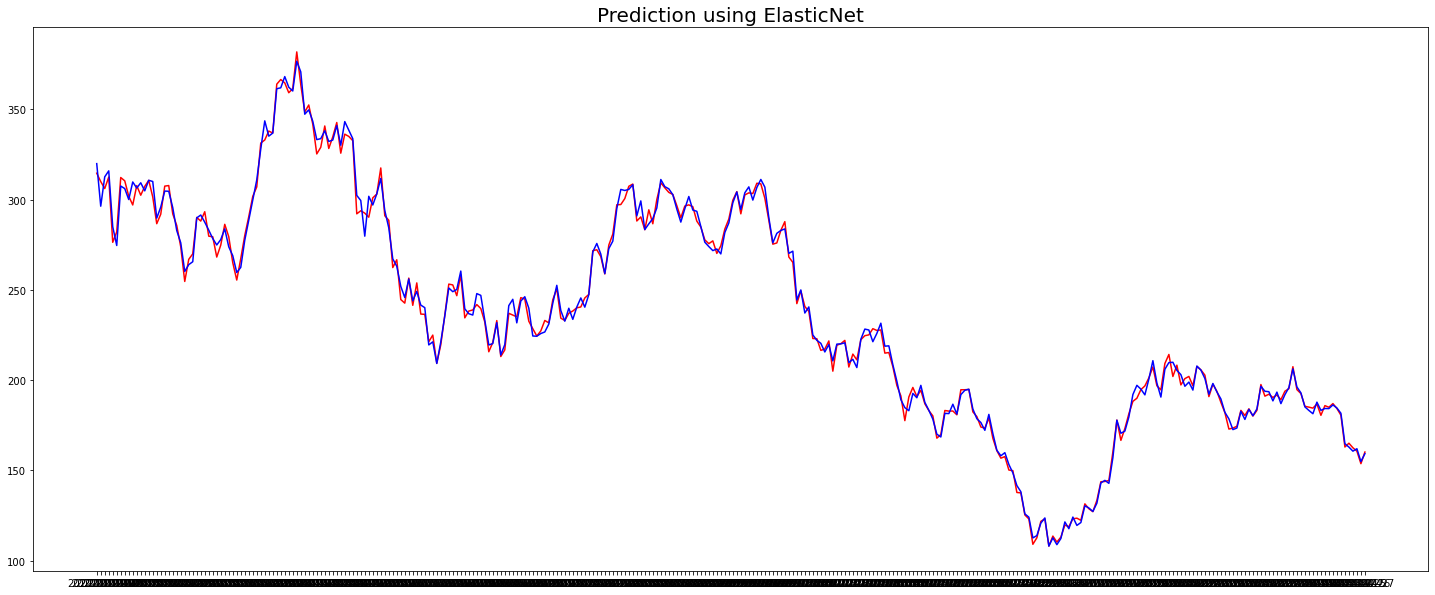

In [17]:
plt.figure(figsize = (25, 10))
plt.plot(y_test, color = 'red', label = 'actual')
plt.plot(y_test_pred_enet, color = 'blue', label = 'prediction')
plt.title("Prediction using ElasticNet", fontdict = {'fontsize': 20})
plt.show()